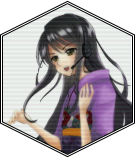

In [2]:
from IPython.display import Image, display
Image("ryoko.png", width="70")

# Message from Dr. Ryoko
"*Hi! I hope you now understand how the Lights Out puzzle works.<br/>The floor of the room I must cross has 3 x 3 tiles. Each tile is made of a single qubit.<br/>
Some of these qubits fluctuate between the ground state and the excited state. <br/> I have been observing their behavior and noticed that there is a pattern - the floor can only be in either one of the four patterns as shown in each of the examples below. <br/>
Due to decoherence, there is not enough time to play around with the switches.<br/> You need to find out which board can be cleared with three switch operations. Good luck!*"<br/>

# Week2-B: Four-Lights Out
In this problem, we are dealing with multiple binary data at the same time. 
We have to determine if each of the given four Lights Out boards are solvable under the given constraints, so let's devise a quantum circuit to solve them all at the same time.

As an example, let's consider how to find a board that can be cleared with just a single switch operation from the 4 boards given below. The initial state of the 4 boards is given in the following two-dimensional array, where "0" and "1" represent "off" and "on" respectively similar to the previous learning problem:

lightsout4_ex=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\]

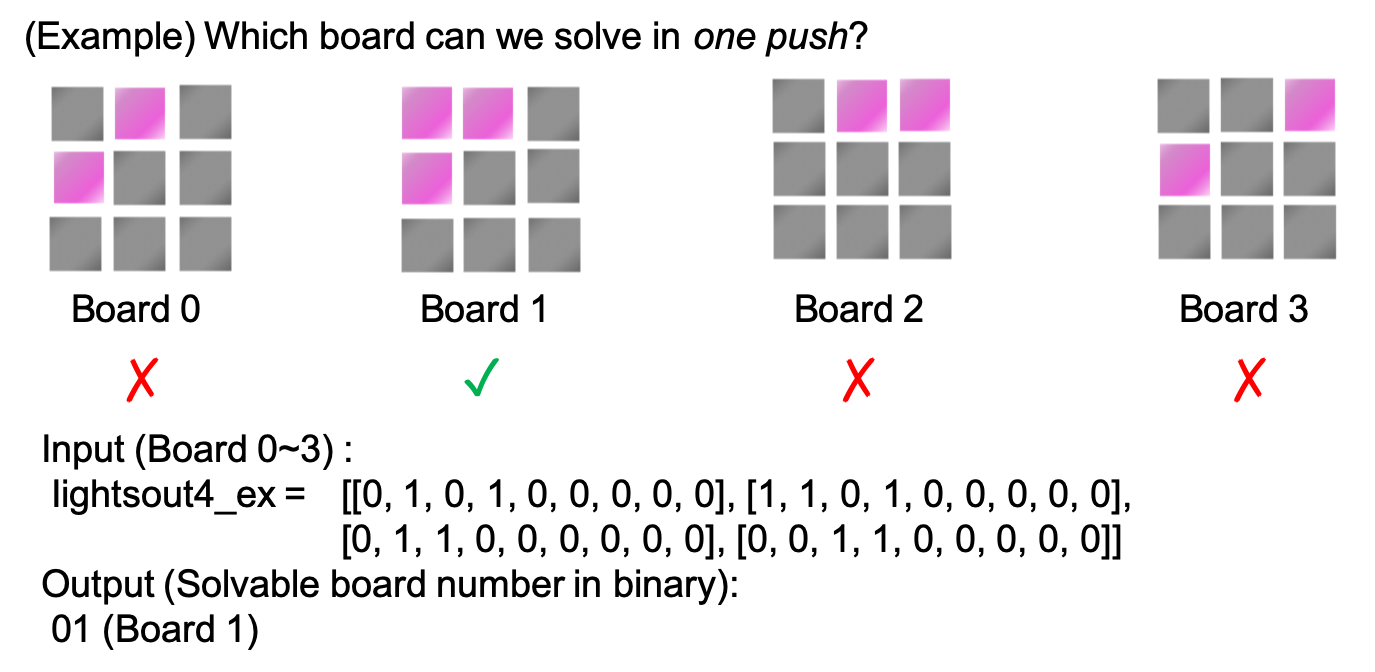

In [6]:
from IPython.display import Image, display
Image('4lightsout_ex.png')

## Answer Strategy
If only one board is given, this is a decision problem.
Using the algorithm from the first Lights Out puzzle (2A), you can solve this problem by counting the "1"s in the output.
 
If we are given multiple boards, there will be several approaches.
1. Iterate the same "one board algorithm" for each board.
2. Hold information for multiple boards at the same time and solve the problems in a single run (execute the algorithm once). 
- For the rest of this document, we discuss how to use the latter approach to solve this type of problem.

First, how do we keep data for all the boards at the same time?
1. Naive data structures:　　9 Qubits/board * 4 boards > 32 qubits (Upper limit of ibm_qasm_simulator).
2. Prepare the  superposition state:   $\vert Board 0\rangle + \vert Board 1\rangle + \vert Board 2\rangle + \vert Board 3\rangle$.
    - The circuit configuration used for state generation is non-trivial.
3. *qRAM* is known as one solution. 
    - **Pros**: Intuitive implementation. 
    - **Cons**: Computationally expensive. 

Of course you can devise and adopt other smart ways to do this.

Here, we will focus on *qRAM* and describe its configuration and implementation.

In [1]:
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
provider = IBMQ.load_account()

c:\users\user\appdata\local\programs\python\python37\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## qRAM: Quantum Random Access Memory

In classical computers, RAM (Random Access Memory) is a type of volatile memory that has memory addresses $j$ and stores binary data corresponding to each address $D_j$.

In the case of [qRAM](https://arxiv.org/abs/0708.1879) in a quantum computer, **address qubits $a$** have the $N$-addresses as superposition and the corresponding binary data is stored in **data qubits $d$** as a state vector.
\\[
\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert 0 \rangle_{d}\xrightarrow{qRAM}\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert D_{j} \rangle_{d}
\\]　　
We call the right-hand side state "qRAM" and the corresponding gate operation "qRAM operation".

Although qRAM operation requires $\mathcal{O}(N\log N)$ gates, it can be used to create superposition states of binary data intuitively.  

qRAM has previously been applied to various quantum machine learning algorithms such as the HHL algorithm. For this problem, let's apply qRAM to Grover's algorithm.

## Example: Find the data from qRAM
Prepare a qRAM of $n$-addresses in which the numbers $k_0, k_1, .. , k_{n-1}$ are stored in this order.  
Find the address in which the number $m$ is stored using Grover's algorithm.  
- $n = 4$
- $k = [1,2,5,7]$
- $m = 7$

### qRAM operation.
Here we show a circuit example of qRAM.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:41: DeprecationWarning: Using `backend_options` kwarg has been deprecated as of qiskit-aer 0.7.0 and will be removed no earlier than 3 months from that release date. Runtime backend options should now be added directly using kwargs for each option.


{'00001': 2008, '10101': 2039, '11111': 1964, '01010': 1989}


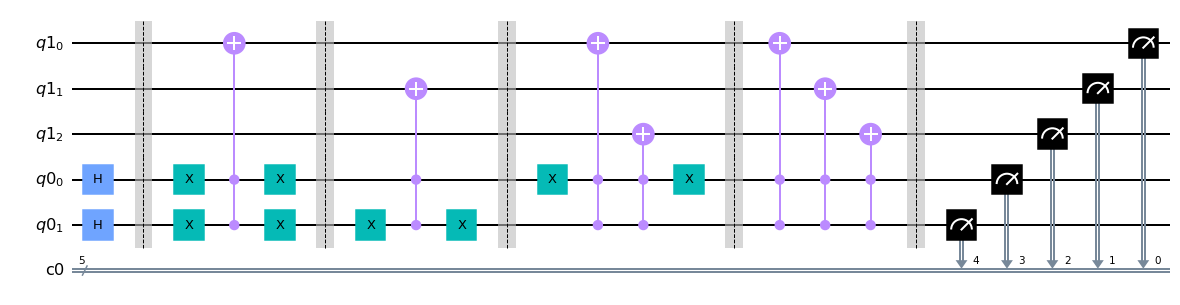

In [2]:
address = QuantumRegister(2)
data = QuantumRegister(3)
c = ClassicalRegister(5)
qc = QuantumCircuit(address,data,c)

# address preparation
qc.h([address[0],address[1]])
qc.barrier()
# address 0 -> data = 1
qc.x([address[0],address[1]])
qc.ccx(address[0],address[1],data[2])
qc.x([address[0],address[1]])
qc.barrier()
# address 1 -> data = 2
qc.x(address[0])
qc.ccx(address[0],address[1],data[1])
qc.x(address[0])
qc.barrier()
# address 2 -> data = 5
qc.x(address[1])
qc.ccx(address[0],address[1],data[2])
qc.ccx(address[0],address[1],data[0])
qc.x(address[1])
qc.barrier()
# address 3 -> data = 7
qc.ccx(address[0],address[1],data[2])
qc.ccx(address[0],address[1],data[1])
qc.ccx(address[0],address[1],data[0])
qc.barrier()


#Check the qRAM　status
qc.measure(address[0:2], c[0:2])
qc.measure(data[0:3], c[2:5])
 
# Reverse the output string.
qc = qc.reverse_bits()

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count =result.get_counts()
print(count)

qc.draw(output='mpl')

### qRAM Data Search
To perform Grover's algorithm, we invert the sign of the **address qubit** containing $m$. We also need to initialize the **data qubit** by another qRAM operation before the Diffusion operation,

\begin{align*}
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f}
\xrightarrow{oracle}  
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j} = m\\
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j}  \neq m
 \end{array}
 \right.
 \xrightarrow{qRAM}
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},  D_{j} = m \\
\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},　D_{j}\neq m
 \end{array}
 \right.
 \end{align*}
 
where $f$ denotes the flag qubit.  

In this case, we can configure an oracle operation using the [C3X gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.C3XGate.html#qiskit.circuit.library.C3XGate) . 

Here, we show the whole circuit for our [qRAM example](#qRAM-Example:-Find-the-data-from-qRAM).

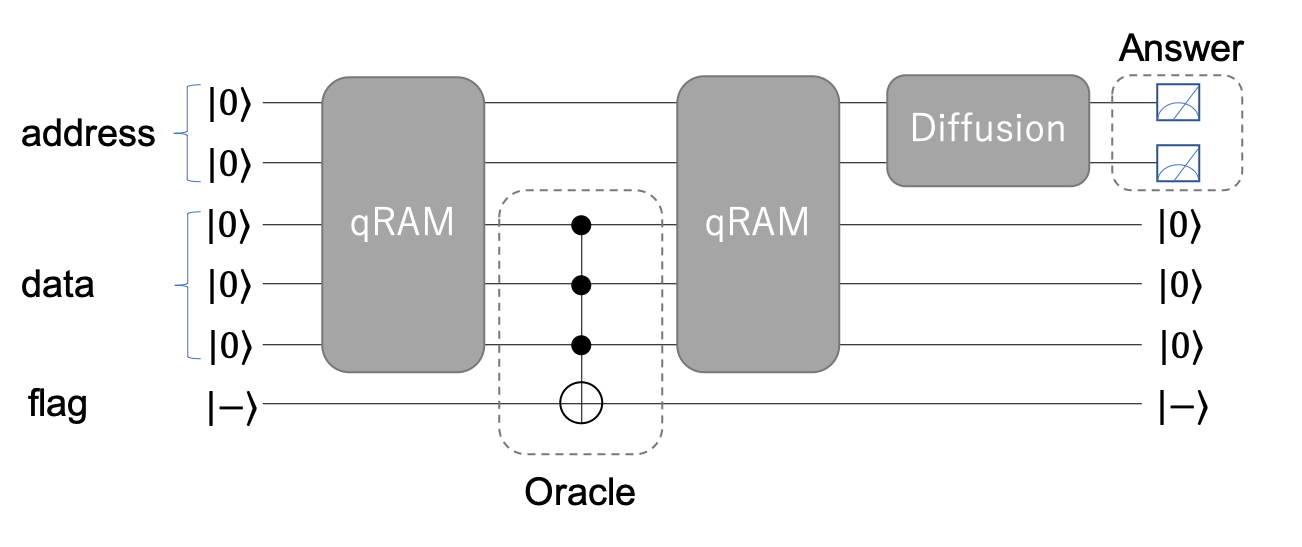

In [3]:
Image('circuit_ex.png')

### Considerations for qRAM implementation
In the above description we have introduced a naive *qRAM operation* circuit.
Depending on the data structure, we can simplify the circuit by using **gate synthesis** (equivalence transformation) techniques.
Also, some simplified gates, e.g. [RCCX](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RCCXGate.html#qiskit.circuit.library.RCCXGate), may help improve your *CNOT*-saving implementation.

An example of gate synthesis is shown below.

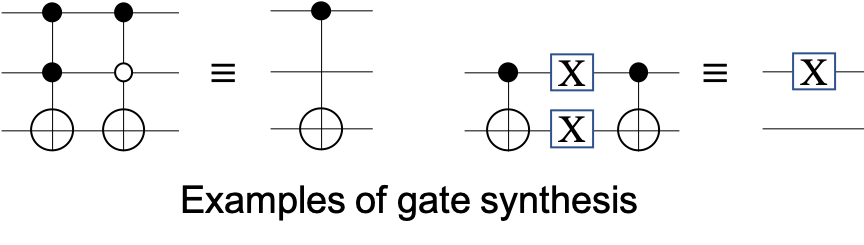

In [4]:
Image('gatesynthesis_ex.png')

## Learning Exercise II-B
Let's solve a 4-Lights Out problem with qRAM.  

When the initial board state lightsout4=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\] is described by the following data, 
determine the _binary_ number of the solvable boards in $3$ switch operations.  (ex. Board 0 → 00, 1 → 01, 2 → 10, 3 → 11)

Answer by creating a quantum circuit to solve the puzzle shown in the figure below. In the quantum circuit to be submitted, measure only the `solution` (2bit) that solves the puzzle.

To submit your solution, create a function which takes "lightsout4" as an input and returns `QuantumCircuit`.  You can choose a function name you like. Make sure it works even if you input another dataset to "lightsout4".

 **In addition, please implement the quantum circuit within 28 qubits.**

Please note that you can get the answer with the same endian as the one used in the description. You can also use the following function.
```python
qc = qc.reverse_bits()
```

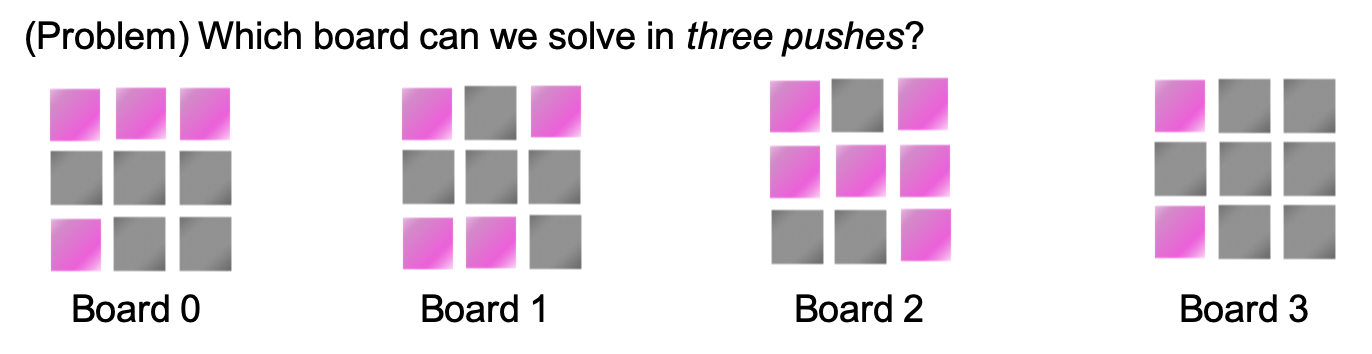

In [5]:
Image('4lightsout_pr.png')

In [3]:
lightsout4=[[1, 1, 1, 0, 0, 0, 1, 0, 0],[1, 0, 1, 0, 0, 0, 1, 1, 0],[1, 0, 1, 1, 1, 1, 0, 0, 1],[1, 0, 0, 0, 0, 0, 1, 0, 0]]

### Hints
- Change the oracle of [qRAM data search](#qRAM-Data-search) to an appropriate one.
- Data storing/writing in *QRAM operation* can be performed in any order. We can reduce the number of gates by taking into account the _hamming distance_ of the address and input data.

In [2]:
lightsout4=[[1, 1, 1, 0, 0, 0, 1, 0, 0],[1, 0, 1, 0, 0, 0, 1, 1, 0],[1, 0, 1, 1, 1, 1, 0, 0, 1],[1, 0, 0, 0, 0, 0, 1, 0, 0]]
# ans: '01'

Q1 = [[0,0,0, 0,0,1, 0,1,1], [0,1,0, 1,0,1, 0,1,0], [0,1,1, 1,0,1, 0,1,0], [1,1,1, 0,1,0, 1,1,0]]
# ans: '00'

Q2 = [[1,0,1, 1,0,1, 0,0,1], [0,1,0, 0,0,1, 1,1,1], [0,1,1, 1,0,0, 1,0,0],[1,0,0, 1,0,0, 1,0,0]]
# ans: '10'

Q3 = [[0,0,0, 0,1,1, 0,0,1], [0,1,0, 1,1,0, 0,0,0], [0,1,1, 1,0,0, 0,0,1], [1,0,0, 0,0,0, 1,0,1]]
# ans: '11'

# Classical Attempts

In [38]:
# classical attempts

def week2b_ans_func(board):
    ##### Build your cirucuit here
    ####  In addition, please make sure your function can solve the problem with different inputs (lightout4). We will cross validate with different inputs.
    from qiskit import QuantumCircuit
    
    # utils
    def decimalToBinary(n, length):
        binary = bin(n).replace("0b", "")
        if len(binary) != length:
            for i in range(length - len(binary)):
                binary = "0" + binary

        return binary

    def sum_mod_2(connection, clicks, grid_light):
        temp = int(clicks[connection[0]]) ^ int(clicks[connection[1]])
        for i in range (len(connection)-2):
            temp = temp ^ int(clicks[connection[2+i]])

        return int(not(temp ^ grid_light))

    def str_to_list(solution):
        temp = []
        for i in range (len(solution)):
            temp += [int(solution[i])]

        return temp
    
    
    # classical search function
    def classical_search(lights):
        connect_list = [
        [0, 1, 3],
        [0, 1, 2, 4],
        [1, 2, 5],
        [0, 3, 4, 6],
        [1, 3, 4, 5, 7],
        [2, 4, 5, 8],
        [3, 6, 7],
        [4, 6, 7, 8],
        [5, 7, 8]
        ]

        N = len(lights)

        for i in range (2**N):
            clicks = decimalToBinary(i, N)
            count_true = 0
            for j in range (N):
                if sum_mod_2(connect_list[j], clicks, lights[j]) == 0:
                    break
                else:
                    count_true += 1
            if count_true == 9:
                solution = str_to_list(clicks)
                break

        return solution
    
    
    # classical search
    for i in range (len(board)):
        ans = classical_search(board[i])
        if sum(ans) == 3:
            mark = i
            break
    
    # convert the answer to quantum circuit
    qc = QuantumCircuit(2,2)
    for i in range (50):
        qc.cx(0,1)

    if mark == 0:
        pass
    elif mark == 1:
        qc.x(1)
    elif mark == 2:
        qc.x(0)
    elif mark == 3:
        qc.x(0)
        qc.x(1)

    qc.measure([0,1],[1,0])
    
    return qc

# Quantum Attempts

In [5]:
#from qiskit.aqua.algorithms import Grover
#from qiskit.aqua.components.oracles import LogicalExpressionOracle

#from qiskit import BasicAer

#from qiskit.tools.visualization import plot_histogram
from qiskit import QuantumCircuit
#from qiskit.circuit.library import WeightedAdder
from qiskit import IBMQ
from qiskit import execute

import numpy as np


In [6]:
# 0-1: address qubits
# 2-10: lights qubits
# 11-19: clicks qubits
# 20-23: sum qubits
# 24: aux/control qubit

def initialize_s(nqubits, qubits):
    qc = QuantumCircuit(nqubits, 2)
        
    """Apply a H-gate to 'address qubits' in qc"""
    qc.h(0)
    qc.h(1)

    """Apply a H-gate to 'clicks qubits' in qc"""
    for q in qubits:
        qc.h(q)

    # flip the last qubit to |1>
    qc.x(nqubits-1)
        
    qc.barrier()

    return qc

In [7]:
n = 25
initialize_s(n, np.linspace(11, 19, 9, dtype=int)).draw()

┌───┐ ░ 
 q_0: ┤ H ├─░─
      ├───┤ ░ 
 q_1: ┤ H ├─░─
      └───┘ ░ 
 q_2: ──────░─
            ░ 
 q_3: ──────░─
            ░ 
 q_4: ──────░─
            ░ 
 q_5: ──────░─
            ░ 
 q_6: ──────░─
            ░ 
 q_7: ──────░─
            ░ 
 q_8: ──────░─
            ░ 
 q_9: ──────░─
            ░ 
q_10: ──────░─
      ┌───┐ ░ 
q_11: ┤ H ├─░─
      ├───┤ ░ 
q_12: ┤ H ├─░─
      ├───┤ ░ 
q_13: ┤ H ├─░─
      ├───┤ ░ 
q_14: ┤ H ├─░─
      ├───┤ ░ 
q_15: ┤ H ├─░─
      ├───┤ ░ 
q_16: ┤ H ├─░─
      ├───┤ ░ 
q_17: ┤ H ├─░─
      ├───┤ ░ 
q_18: ┤ H ├─░─
      ├───┤ ░ 
q_19: ┤ H ├─░─
      └───┘ ░ 
q_20: ──────░─
            ░ 
q_21: ──────░─
            ░ 
q_22: ──────░─
            ░ 
q_23: ──────░─
      ┌───┐ ░ 
q_24: ┤ X ├─░─
      └───┘ ░ 
 c: 2/════════

In [8]:
# 0-1: address qubits
# 2-10: lights qubits
# 11-19: clicks qubits
# 20-23: sum qubits
# 24-26: carry qubits
# 27: aux/control qubit

def qRAM(qc, nqubits, board):
    
    for i in range (len(board)):
    # board configuration loop
    
        # asign the address to address qubits
        if i == 0:
            qc.x(0)
            qc.x(1)
        elif i == 1:
            qc.x(0)
        elif i == 2:
            qc.x(1)
    
        for j in range (len(board[i])):
        # grid's lights configuration loop
            if board[i][j] == 1:
                qc.mct(list(np.linspace(0, 1, 2, dtype=int)), j+2)
                
        # return address qubits to |00>
        if i == 0:
            qc.x(0)
            qc.x(1)
        elif i == 1:
            qc.x(0)
        elif i == 2:
            qc.x(1)
            
        qc.barrier()
    
    return qc

In [10]:
n = 25
qc = initialize_s(n, np.linspace(11, 19, 9, dtype=int))
qRAM(qc, n, lightsout4).draw()

┌───┐ ░ ┌───┐                    ┌───┐ ░ ┌───┐                    ┌───┐»
 q_0: ┤ H ├─░─┤ X ├──■────■────■────■──┤ X ├─░─┤ X ├──■────■────■────■──┤ X ├»
      ├───┤ ░ ├───┤  │    │    │    │  ├───┤ ░ └───┘  │    │    │    │  └───┘»
 q_1: ┤ H ├─░─┤ X ├──■────■────■────■──┤ X ├─░────────■────■────■────■───────»
      └───┘ ░ └───┘┌─┴─┐  │    │    │  └───┘ ░      ┌─┴─┐  │    │    │       »
 q_2: ──────░──────┤ X ├──┼────┼────┼────────░──────┤ X ├──┼────┼────┼───────»
            ░      └───┘┌─┴─┐  │    │        ░      └───┘  │    │    │       »
 q_3: ──────░───────────┤ X ├──┼────┼────────░─────────────┼────┼────┼───────»
            ░           └───┘┌─┴─┐  │        ░           ┌─┴─┐  │    │       »
 q_4: ──────░────────────────┤ X ├──┼────────░───────────┤ X ├──┼────┼───────»
            ░                └───┘  │        ░           └───┘  │    │       »
 q_5: ──────░───────────────────────┼────────░──────────────────┼────┼───────»
            ░                       │        ░                  │    │       »
 q_6: ──────░───────────────────────┼────────░──────────────────┼────┼───────»
            ░                       │        ░                  │    │       »
 q_7: ──────░───────────────────────┼────────░──────────────────┼────┼───────»
            ░                     ┌─┴─┐      ░                ┌─┴─┐  │       »
 q_8: ──────░─────────────────────┤ X ├──────░────────────────┤ X ├──┼───────»
            ░                     └───┘      ░                └───┘┌─┴─┐     »
 q_9: ──────░────────────────────────────────░─────────────────────┤ X ├─────»
            ░                                ░                     └───┘     »
q_10: ──────░────────────────────────────────░───────────────────────────────»
      ┌───┐ ░                                ░                               »
q_11: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_12: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_13: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_14: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_15: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_16: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_17: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_18: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_19: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      └───┘ ░                                ░                               »
q_20: ──────░────────────────────────────────░───────────────────────────────»
            ░                                ░                               »
q_21: ──────░────────────────────────────────░───────────────────────────────»
            ░                                ░                               »
q_22: ──────░────────────────────────────────░───────────────────────────────»
            ░                                ░                               »
q_23: ──────░────────────────────────────────░───────────────────────────────»
      ┌───┐ ░                                ░                               »
q_24: ┤ X ├─░────────────────────────────────░───────────────────────────────»
      └───┘ ░                                ░          

In [11]:
# a circuit that will do the XOR operation on the clicks qubits and the lights qubits

# 0-1: address qubits
# 2-10: lights qubits
# 11-19: clicks qubits
# 20-23: sum qubits
# 24-26: carry qubits
# 27: aux/control qubit

def XOR_oracle(qc, nqubits):
    
    # the connection between grid
    connect_list = [
        [0, 1, 3],
        [0, 1, 2, 4],
        [1, 2, 5],
        [0, 3, 4, 6],
        [1, 3, 4, 5, 7],
        [2, 4, 5, 8],
        [3, 6, 7],
        [4, 6, 7, 8],
        [5, 7, 8]
        ]
    
    # XOR operation for every grid
    for i in range (9):
        # XOR operation between current grid's click to adjacent grids' click and to current grid's light
        for j in range (len(connect_list[i])):
            qc.cx(connect_list[i][j]+11, i+2)

        # SAME operation between current grid to current grid's light input
        # note: X SAME Y = X == Y = NOT(X XOR Y)
        # XOR operation between current grid to current grid's light input has been done
        # only need to do the 'NOT' part
        # NOT operation
        qc.x(i+2)
        qc.barrier()
        
    return qc

In [12]:
n = 25
qc = initialize_s(n, np.linspace(11, 19, 9, dtype=int))
qc = qRAM(qc, n, lightsout4)
XOR_oracle(qc, n).draw()

┌───┐ ░ ┌───┐                    ┌───┐ ░ ┌───┐                    ┌───┐»
 q_0: ┤ H ├─░─┤ X ├──■────■────■────■──┤ X ├─░─┤ X ├──■────■────■────■──┤ X ├»
      ├───┤ ░ ├───┤  │    │    │    │  ├───┤ ░ └───┘  │    │    │    │  └───┘»
 q_1: ┤ H ├─░─┤ X ├──■────■────■────■──┤ X ├─░────────■────■────■────■───────»
      └───┘ ░ └───┘┌─┴─┐  │    │    │  └───┘ ░      ┌─┴─┐  │    │    │       »
 q_2: ──────░──────┤ X ├──┼────┼────┼────────░──────┤ X ├──┼────┼────┼───────»
            ░      └───┘┌─┴─┐  │    │        ░      └───┘  │    │    │       »
 q_3: ──────░───────────┤ X ├──┼────┼────────░─────────────┼────┼────┼───────»
            ░           └───┘┌─┴─┐  │        ░           ┌─┴─┐  │    │       »
 q_4: ──────░────────────────┤ X ├──┼────────░───────────┤ X ├──┼────┼───────»
            ░                └───┘  │        ░           └───┘  │    │       »
 q_5: ──────░───────────────────────┼────────░──────────────────┼────┼───────»
            ░                       │        ░                  │    │       »
 q_6: ──────░───────────────────────┼────────░──────────────────┼────┼───────»
            ░                       │        ░                  │    │       »
 q_7: ──────░───────────────────────┼────────░──────────────────┼────┼───────»
            ░                     ┌─┴─┐      ░                ┌─┴─┐  │       »
 q_8: ──────░─────────────────────┤ X ├──────░────────────────┤ X ├──┼───────»
            ░                     └───┘      ░                └───┘┌─┴─┐     »
 q_9: ──────░────────────────────────────────░─────────────────────┤ X ├─────»
            ░                                ░                     └───┘     »
q_10: ──────░────────────────────────────────░───────────────────────────────»
      ┌───┐ ░                                ░                               »
q_11: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_12: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_13: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_14: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_15: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_16: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_17: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_18: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_19: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      └───┘ ░                                ░                               »
q_20: ──────░────────────────────────────────░───────────────────────────────»
            ░                                ░                               »
q_21: ──────░────────────────────────────────░───────────────────────────────»
            ░                                ░                               »
q_22: ──────░────────────────────────────────░───────────────────────────────»
            ░                                ░                               »
q_23: ──────░────────────────────────────────░───────────────────────────────»
      ┌───┐ ░                                ░                               »
q_24: ┤ X ├─░────────────────────────────────░───────────────────────────────»
      └───┘ ░                                ░          

In [13]:
def counter(qc, nodes, counter_aux):
    for i in range (len(nodes)):
        qc.mct([nodes[i], counter_aux[0], counter_aux[1], counter_aux[2]] , counter_aux[3])
        qc.mct([nodes[i], counter_aux[0], counter_aux[1]] , counter_aux[2])
        qc.ccx(nodes[i], counter_aux[0], counter_aux[1])
        qc.cx(nodes[i], counter_aux[0])
        qc.barrier()
        
    return qc

In [14]:
# circuit that will count the number of '1' in the clicks qubits
# and flip the aux qubit to |1> iff all lights qubits are 1 and sum qubits = |1100>

# 0-1: address qubits
# 2-10: lights qubits
# 11-19: clicks qubits
# 20-23: sum qubits
# 24: aux/control qubit

def counter_oracle(qc, nqubits):
    
    # Adder operation: counts every 1 in clicks qubits and output the result to sum qubits in binary
    # ex: if there are three '1' in clicks qubits, then sum qubits = |1100> (from top to bottom)
    qc = counter(qc, list(np.linspace(11, 19, 9, dtype=int)), list(np.linspace(20, 23, 4, dtype=int)))
    
    # MC-Phase operation
    # control: lights qubits after all XOR and NOT operation + adder output
    # target: aux qubit
    # we want to flip the phase iff all lights qubits are 1 and sum qubits = |1100>
    qc.x(22)
    qc.x(23)
    qc.h(nqubits-1)
    qc.mct(list(np.linspace(2, 10, 9, dtype=int)) + list(np.linspace(20, 23, 4, dtype=int)), nqubits-1)
    qc.h(nqubits-1)
    qc.x(22)
    qc.x(23)
    
    # UNCOMPUTATION
    qc = counter(qc, list(np.linspace(11, 19, 9, dtype=int)), list(np.linspace(20, 23, 4, dtype=int)))
    
    return qc

In [15]:
n = 25
qc = initialize_s(n, np.linspace(11, 19, 9, dtype=int))
qc = qRAM(qc, n, lightsout4)
qc = XOR_oracle(qc, n)
counter_oracle(qc, n).draw()

┌───┐ ░ ┌───┐                    ┌───┐ ░ ┌───┐                    ┌───┐»
 q_0: ┤ H ├─░─┤ X ├──■────■────■────■──┤ X ├─░─┤ X ├──■────■────■────■──┤ X ├»
      ├───┤ ░ ├───┤  │    │    │    │  ├───┤ ░ └───┘  │    │    │    │  └───┘»
 q_1: ┤ H ├─░─┤ X ├──■────■────■────■──┤ X ├─░────────■────■────■────■───────»
      └───┘ ░ └───┘┌─┴─┐  │    │    │  └───┘ ░      ┌─┴─┐  │    │    │       »
 q_2: ──────░──────┤ X ├──┼────┼────┼────────░──────┤ X ├──┼────┼────┼───────»
            ░      └───┘┌─┴─┐  │    │        ░      └───┘  │    │    │       »
 q_3: ──────░───────────┤ X ├──┼────┼────────░─────────────┼────┼────┼───────»
            ░           └───┘┌─┴─┐  │        ░           ┌─┴─┐  │    │       »
 q_4: ──────░────────────────┤ X ├──┼────────░───────────┤ X ├──┼────┼───────»
            ░                └───┘  │        ░           └───┘  │    │       »
 q_5: ──────░───────────────────────┼────────░──────────────────┼────┼───────»
            ░                       │        ░                  │    │       »
 q_6: ──────░───────────────────────┼────────░──────────────────┼────┼───────»
            ░                       │        ░                  │    │       »
 q_7: ──────░───────────────────────┼────────░──────────────────┼────┼───────»
            ░                     ┌─┴─┐      ░                ┌─┴─┐  │       »
 q_8: ──────░─────────────────────┤ X ├──────░────────────────┤ X ├──┼───────»
            ░                     └───┘      ░                └───┘┌─┴─┐     »
 q_9: ──────░────────────────────────────────░─────────────────────┤ X ├─────»
            ░                                ░                     └───┘     »
q_10: ──────░────────────────────────────────░───────────────────────────────»
      ┌───┐ ░                                ░                               »
q_11: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_12: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_13: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_14: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_15: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_16: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_17: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_18: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      ├───┤ ░                                ░                               »
q_19: ┤ H ├─░────────────────────────────────░───────────────────────────────»
      └───┘ ░                                ░                               »
q_20: ──────░────────────────────────────────░───────────────────────────────»
            ░                                ░                               »
q_21: ──────░────────────────────────────────░───────────────────────────────»
            ░                                ░                               »
q_22: ──────░────────────────────────────────░───────────────────────────────»
            ░                                ░                               »
q_23: ──────░────────────────────────────────░───────────────────────────────»
      ┌───┐ ░                                ░                               »
q_24: ┤ X ├─░────────────────────────────────░───────────────────────────────»
      └───┘ ░                                ░          

In [16]:
def diffuser(nqubits):
        qc = QuantumCircuit(nqubits)
        # Apply transformation |s> -> |00..0> (H-gates)
        for qubit in range(nqubits):
            qc.h(qubit)
        # Apply transformation |00..0> -> |11..1> (X-gates)
        for qubit in range(nqubits):
            qc.x(qubit)
        # Do multi-controlled-Z gate
        qc.h(nqubits-1)
        qc.mct(list(range(nqubits-1)), nqubits-1) # multi-controlled-toffoli
        qc.h(nqubits-1)
        # Apply transformation |11..1> -> |00..0>
        for qubit in range(nqubits):
            qc.x(qubit)
        # Apply transformation |00..0> -> |s>
        for qubit in range(nqubits):
            qc.h(qubit)
        # We will return the diffuser as a gate
        U_s = qc.to_gate()
        U_s.name = "$U_s$"
        return U_s

In [18]:
def week2b_ans_func(board, repeat=1):
    ##### Build your cirucuit here
    ####  In addition, please make sure your function can solve the problem with different inputs (lightout4). We will cross validate with different inputs.

    # 2 address qubits + 9 lights qubits + 9 clicks qubits + 4 sum qubits + 3 carry qubits + 1 aux qubit = 28
    n = 25

    # initialization
    qc = initialize_s(n, np.linspace(11, 19, 9, dtype=int))

    # oracle repetition
    iteration = repeat
    for i in range (iteration):

        # COMPUTATION
        qc = qRAM(qc, n, board)
        qc = XOR_oracle(qc, n)

        # Counter and phase-flip
        qc = counter_oracle(qc, n)

        # UNCOMPUTATION to return all the copy of clicks qubits back to |000...000>
        qc = XOR_oracle(qc, n)
        qc = qRAM(qc, n, board)

        # Diffuser: put the diffuser only on the address qubits
        qc.append(diffuser(2), list(range(2)))

    # measurement: measure only the address qubits
    # the qubits order is flipped as Qiskit starts the measurement results from the bottom most qubit
    qc.measure([0,1], [1,0])
    
    return qc

In [41]:
Q1

[[0, 0, 0, 0, 0, 1, 0, 1, 1],
 [0, 1, 0, 1, 0, 1, 0, 1, 0],
 [0, 1, 1, 1, 0, 1, 0, 1, 0],
 [1, 1, 1, 0, 1, 0, 1, 1, 0]]

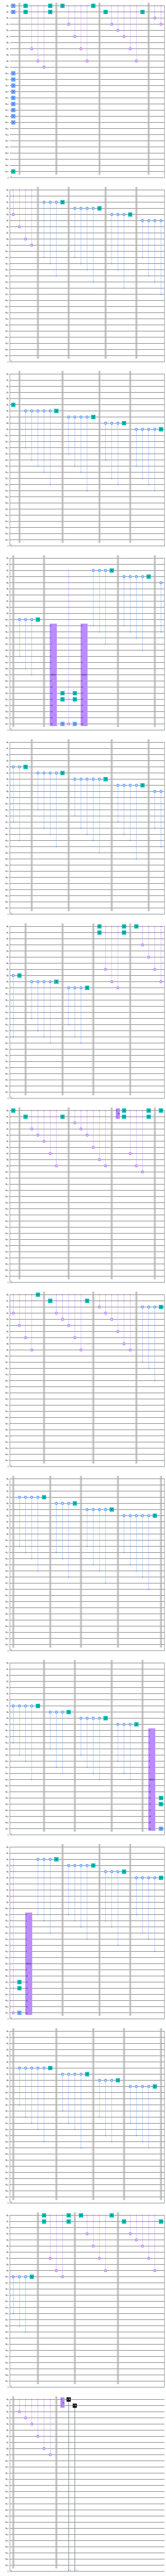

In [70]:
week2b_ans_func(Q1, repeat=2).draw()

In [83]:
# load account

IBMQ.load_account()
provider_real = IBMQ.get_provider(hub='ibm-q')
device_real = provider_real.get_backend('ibmq_qasm_simulator')

ibmqfactory.load_account:WARNING:2020-11-21 15:33:14,855: Credentials are already in use. The existing account in the session will be replaced.


In [ ]:
##### testing the circuit for 1 iteration (sanity check)

# backend = BasicAer.get_backend ('qasm_simulator')

job = execute(week2b_ans_func(Q1, repeat=25), backend=device_real, shots=8000)
result = job.result()
count = result.get_counts()
print(count)

In [88]:
##### testing the circuit for 1 iteration (sanity check)

# backend = BasicAer.get_backend ('qasm_simulator')

job = execute(week2b_ans_func(Q2, repeat=20), backend=device_real, shots=8000)
result = job.result()
count = result.get_counts()
print(count)

{'00': 1966, '01': 1984, '10': 2047, '11': 2003}


In [87]:
##### testing the circuit for 1 iteration (sanity check)

# backend = BasicAer.get_backend ('qasm_simulator')

job = execute(week2b_ans_func(Q3, repeat=18), backend=device_real, shots=8000)
result = job.result()
count = result.get_counts()
print(count)

{'00': 1948, '01': 2027, '10': 1974, '11': 2051}


In [92]:
##### testing the circuit for 1 iteration (sanity check)

# backend = BasicAer.get_backend ('qasm_simulator')

job = execute(week2b_ans_func(lightsout4, repeat=1), backend=device_real, shots=8000)
result = job.result()
count = result.get_counts()
print(count)

{'00': 1922, '01': 2055, '10': 1986, '11': 2037}


# ----------------------------------------------------------------------

In [78]:
# Submission code
from qc_grader import prepare_ex2b, grade_ex2b, submit_ex2b

# Execute your circuit with following prepare_ex2b() function.
# The prepare_ex2b() function works like the execute() function with only QuantumCircuit as an argument.
job  =  prepare_ex2b(week2b_ans_func)

result = job.result()
count = result.get_counts()
original_problem_set_counts = count[0]

original_problem_set_counts
# The bit string with the highest number of observations is treated as the solution.

Running week2b_ans_func...
Computing cost...
Starting experiments. Please wait...
You may monitor the job (id: 5fb92a1fe0893f001933d667) status and proceed to grading when it successfully completes.


{'00': 1916, '01': 2086, '10': 2034, '11': 1964}

In [79]:
# Check your answer by executing following code.
# The quantum cost of the QuantumCircuit is obtained as the score. The quantum cost is related to rank only in the third week.
grade_ex2b(job)

Grading your answer. Please wait...

Congratulations 🎉! Your answer is correct.
Your score is 295789.
Feel free to submit your answer.


In [80]:
# Submit your results by executing following code. You can submit as many times as you like during the period. 
submit_ex2b(job)

Submitting your answer. Please wait...

Success 🎉! Your answer has been submitted.
There seems to be huge "noise clusters" interfering with Dr. Ryoko’s device. Can you please help?
